Import Libraries

In [1]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

Import and read the data

In [2]:
EOSINOPHIL_dir = [r'dataset2-master/images\data\EOSINOPHIL']
LYMPHOCYTE_dir = [r'dataset2-master/images\data\LYMPHOCYTE']
MONOCYTE_dir = [r'dataset2-master/images\data\MONOCYTE']
NEUTROPHIL_dir = [r'dataset2-master/images\data\NEUTROPHIL']

import os

filepaths = []
labels = []
dict_list = [EOSINOPHIL_dir, LYMPHOCYTE_dir, MONOCYTE_dir, NEUTROPHIL_dir]
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


for i, dir_list in enumerate(dict_list):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())
print(bloodCell_df["labels"].value_counts())

total = len(labels)
print(f"\nTotal files: {total}")

                                           filepaths      labels
0  dataset2-master/images\data\EOSINOPHIL\_0_1169...  EOSINOPHIL
1  dataset2-master/images\data\EOSINOPHIL\_0_1414...  EOSINOPHIL
2  dataset2-master/images\data\EOSINOPHIL\_0_207....  EOSINOPHIL
3  dataset2-master/images\data\EOSINOPHIL\_0_2142...  EOSINOPHIL
4  dataset2-master/images\data\EOSINOPHIL\_0_2370...  EOSINOPHIL
labels
NEUTROPHIL    2499
EOSINOPHIL    2497
LYMPHOCYTE    2483
MONOCYTE      2478
Name: count, dtype: int64

Total files: 9957


In [3]:
bloodCell_df.shape

(9957, 2)

Train test split

In [7]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(bloodCell_df, test_size=0.2, random_state=42)

In [8]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(7965, 2)
(2988, 2)
(1992, 2)
(6969, 2)


# Import pretrained model (we use mobilenetv2)

In [9]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=8,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 7965 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


In [10]:
classes=list(train.class_indices.keys())
print (classes)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


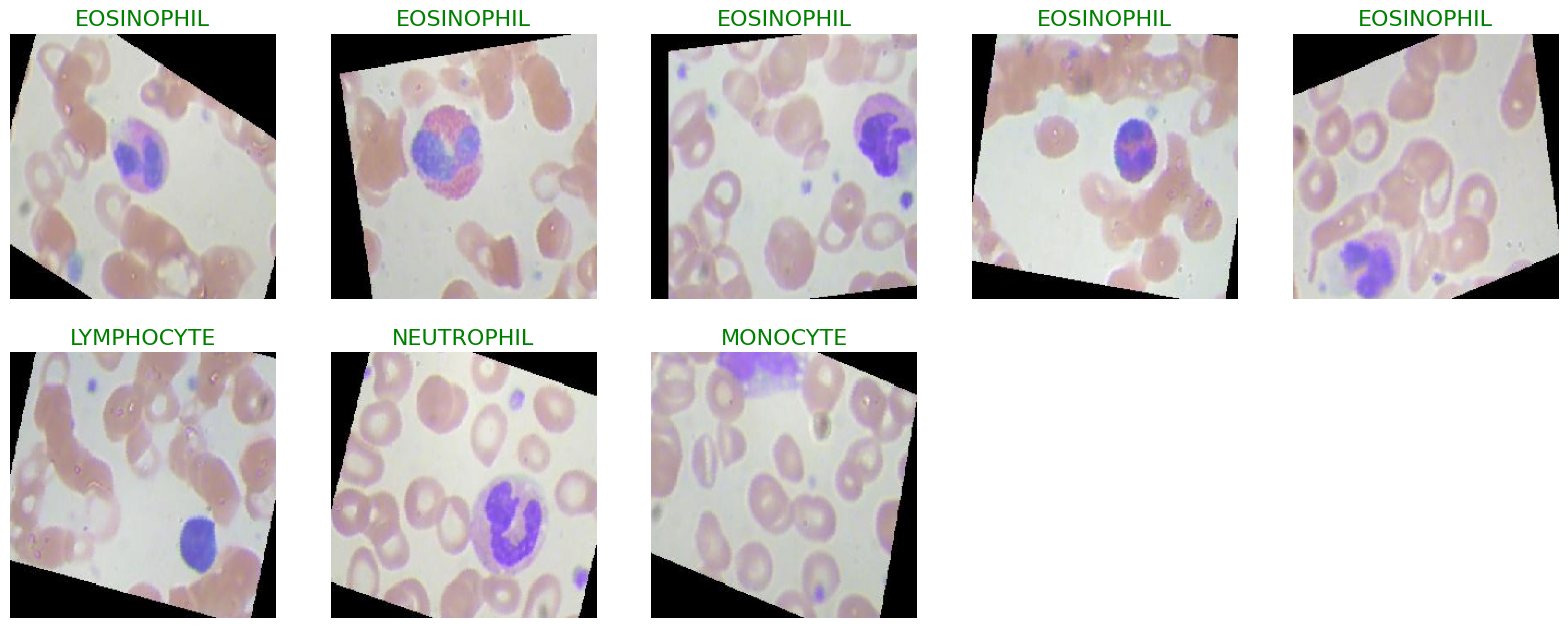

In [11]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

# Create the Model

In [12]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Batc  (None, 73, 73, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 256)      0         
 )                                                               
                                                        

In [13]:
!nvidia-smi

Fri Jul 26 16:22:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P0             10W /  125W |    5655MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
history = model.fit(train, epochs=11, validation_data=val, verbose=1)

Epoch 1/11
996/996 [==============================] - 63s 52ms/step - loss: 1.5928 - accuracy: 0.3774 - val_loss: 1.0396 - val_accuracy: 0.5487
Epoch 2/11
996/996 [==============================] - 49s 50ms/step - loss: 1.0687 - accuracy: 0.5287 - val_loss: 0.7835 - val_accuracy: 0.6948
Epoch 3/11
996/996 [==============================] - 49s 49ms/step - loss: 0.7777 - accuracy: 0.6736 - val_loss: 0.6504 - val_accuracy: 0.7254
Epoch 4/11
996/996 [==============================] - 49s 49ms/step - loss: 0.5035 - accuracy: 0.8004 - val_loss: 0.3953 - val_accuracy: 0.8464
Epoch 5/11
996/996 [==============================] - 50s 50ms/step - loss: 0.3546 - accuracy: 0.8642 - val_loss: 0.2118 - val_accuracy: 0.9116
Epoch 6/11
996/996 [==============================] - 49s 50ms/step - loss: 0.2594 - accuracy: 0.8988 - val_loss: 0.1849 - val_accuracy: 0.9187
Epoch 7/11
996/996 [==============================] - 49s 50ms/step - loss: 0.1985 - accuracy: 0.9255 - val_loss: 0.1398 - val_accuracy:

In [15]:
model.evaluate(test, verbose=1)

374/374 [==============================] - 6s 16ms/step - loss: 0.1305 - accuracy: 0.9495


[0.13051912188529968, 0.9494644999504089]

In [16]:
model.save("Blood_Cell.h5")


In [17]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

374/374 [==============================] - 5s 13ms/step


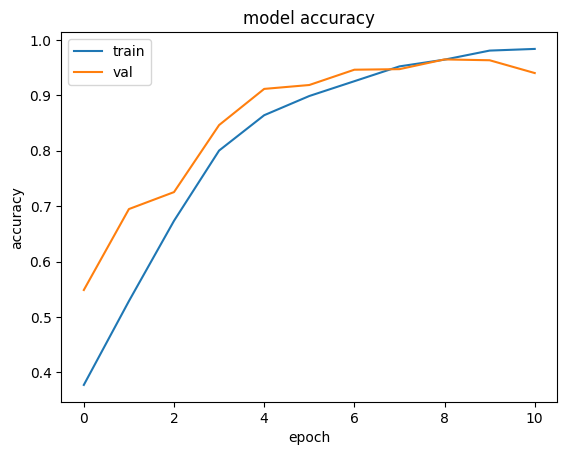

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


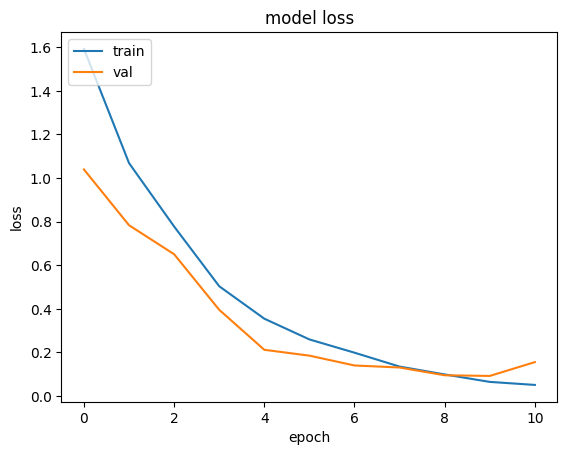

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

  EOSINOPHIL       0.96      0.90      0.93       781
  LYMPHOCYTE       1.00      1.00      1.00       764
    MONOCYTE       1.00      0.94      0.97       729
  NEUTROPHIL       0.85      0.96      0.90       714

    accuracy                           0.95      2988
   macro avg       0.95      0.95      0.95      2988
weighted avg       0.95      0.95      0.95      2988

Accuracy of the Model: 94.9%


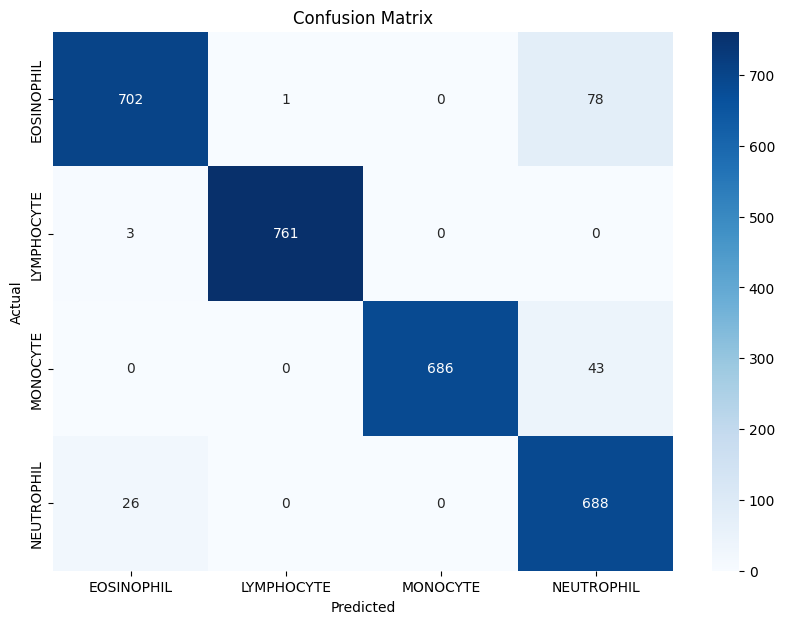

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

1/1 [==============================] - 0s 17ms/step
This image most likely belongs to LYMPHOCYTE with a 47.54 percent confidence.


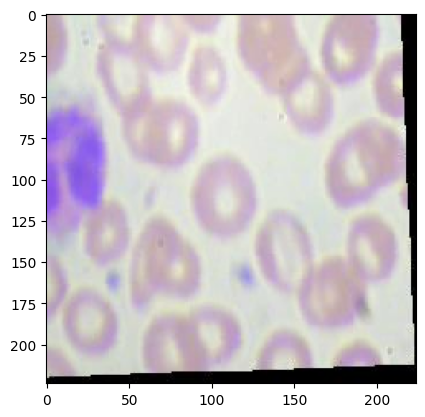

In [34]:
# predict an image
import keras.utils as image
import numpy as np

img_path = 'dataset2-master/images/data/NEUTROPHIL/_0_292.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)
# actual label
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()